# Introduction

My theoretical work has focused on the demand forecasting in the supply chain management. And I choose the same topic for my practical work to gain practical experience. The Notebook will try to explore and forecast demand of 50 different articles at 10 different locations of a big retail chain.

We are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.

In [135]:
#pip install statsmodels

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest
%matplotlib inline

In [137]:
import warnings
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

In [138]:
train_data = pd.read_csv("C:/Users/dhema/Documents/demand-forecasting-kernels-only/train.csv")
test_data = pd.read_csv("C:/Users/dhema/Documents/demand-forecasting-kernels-only/test.csv")

In [139]:
print("Shape",train_data.shape )
train_data.dtypes


Shape (913000, 4)


date     object
store     int64
item      int64
sales     int64
dtype: object

In [140]:
# Change date time format
train_data['date'] = pd.to_datetime(train_data['date'], format="%Y-%m-%d")
print(train_data.dtypes)
train_data.head()

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [141]:
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
train_data['day'] = train_data['date'].dt.day
train_data['weekday'] = train_data['date'].dt.weekday

train_data.head()

,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


In [142]:
train_data['day'].max()

31

### Vizualization

Let's visualize for a particular store and a particular item in that store.

In [143]:
train_data_1 = train_data[(train_data['store']==1) & (train_data['item']==1) ]
train_data_1.head()


,date,store,item,sales,year,month,day,weekday
0,2013-01-01,1,1,13,2013,1,1,1
1,2013-01-02,1,1,11,2013,1,2,2
2,2013-01-03,1,1,14,2013,1,3,3
3,2013-01-04,1,1,13,2013,1,4,4
4,2013-01-05,1,1,10,2013,1,5,5


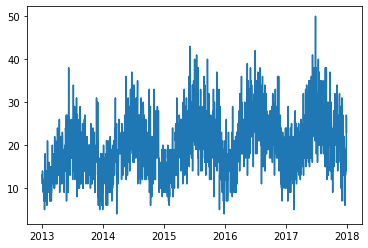

In [144]:
plt.plot(train_data_1['date'],train_data_1['sales'])
plt.show()

Monday=0, SUnday = 6


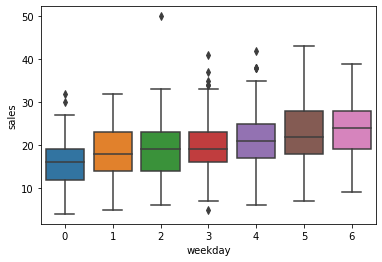

In [145]:
sns.boxplot(x='weekday', y='sales', data=train_data_1)
print("Monday=0, SUnday = 6")

We see that there are usually more sales happening in the weekends(5 & 6) and we also see some outliers.

## Time Series Decomposition

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [147]:
train_data_1 = train_data_1.set_index('date')

<Figure size 1440x1440 with 0 Axes>

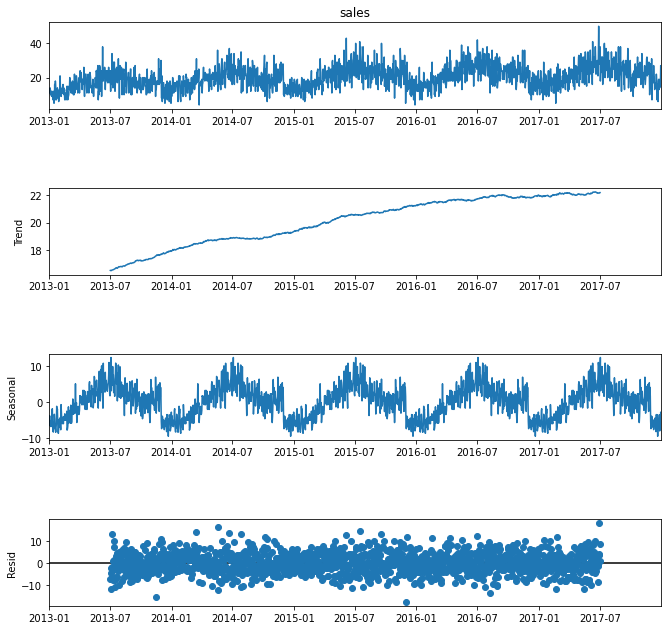

In [148]:
decomp = seasonal_decompose(train_data_1['sales'], model='additive', period=365)
fig = plt.figure(figsize=(20,20))
fig = decomp.plot()
fig.set_size_inches(10,10)
plt.show()

We have a few observations from the above plot. We clearly see seasonality in the sales of the article item 1 and it is yearly. The sales increase until the mid of the year and drop towards the year end. Also we see an upward trend.

## Stationary OR Non Stationary?

As we know for the basic assumption that the observations are independent to hold, we need the time series data(whihc is time dependent) to be stationary meaning the mean and variance should not be a fucntion of time.

Two ways to check for stationarity of the series

- Classical Plots on Mean & Variance
- Dickey-Fuller test

Ref : https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

In [149]:
def isStationary(data, window = 12):
    mean = data.rolling(window).mean()
    std = data.rolling(window).std()
    plt.figure(figsize=(12,6))
    plt.plot(data, label='original')
    plt.plot(mean, label='Rolling MEan')
    plt.plot(std, label='Rolling STD')
    plt.title('Mean & Standard Deviation Of Time series Of Sales')
    plt.legend(loc='upper left')
    plt.show()

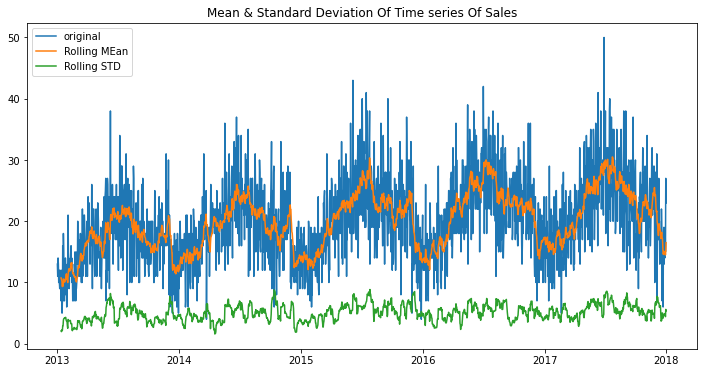

In [150]:
isStationary(train_data_1['sales'], 12)

In [151]:
# Dickey Fuller test
from statsmodels.tsa.stattools import adfuller

def adfTest(data, cutoff = 0.05):
    adf = adfuller(data, autolag='AIC', maxlag=20)
    out = pd.Series(adf[0:4], index=['Test Static', 'p-value', '# Of Lags', '# Of Obs'])
    for key, val in adf[4].items():
        out['Critical Value(%s)'%key] = val
    
    if out[1]<cutoff:
        print("The p-value %.4f is less than Cutoff %.2f . Series is likely Stationary"%(out[1],cutoff))
    else:
        print("The p-value %.4f is more than Cutoff %.2f. Series is likely Non Stationary"%(out[1], cutoff))
    print(out)
    

In [152]:
adfTest(train_data_1['sales'])

The p-value 0.0361 is less than Cutoff 0.05 . Series is likely Stationary
Test Static              -2.987278
p-value                   0.036100
# Of Lags                20.000000
# Of Obs               1805.000000
Critical Value(1%)       -3.433978
Critical Value(5%)       -2.863143
Critical Value(10%)      -2.567623
dtype: float64


We see that the series is likely stationary. However from the plots we see the rolling mean increase over time and that is why we can set a lower cutoff at 0.01

In [153]:
# cutoff at 0.01 for Dickey-Fuller test

adfTest(train_data_1['sales'], cutoff = 0.01)

The p-value 0.0361 is more than Cutoff 0.01. Series is likely Non Stationary
Test Static              -2.987278
p-value                   0.036100
# Of Lags                20.000000
# Of Obs               1805.000000
Critical Value(1%)       -3.433978
Critical Value(5%)       -2.863143
Critical Value(10%)      -2.567623
dtype: float64


### Differencing

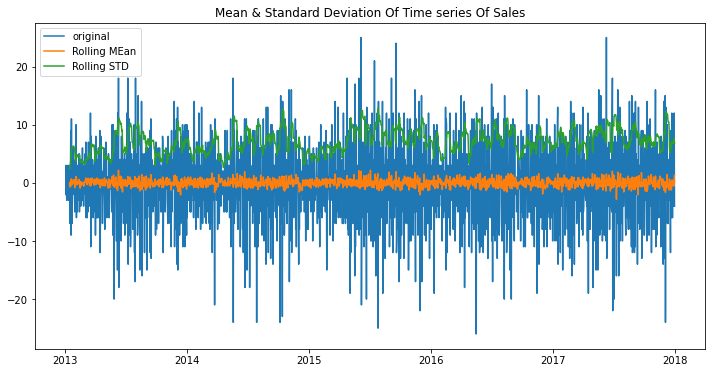

In [154]:
train_data_1_sales_diff = train_data_1.sales - train_data_1.sales.shift(1)
train_data_1_sales_diff.dropna(inplace=True)
isStationary(train_data_1_sales_diff, 12)

In [155]:
adfTest(train_data_1_sales_diff, cutoff=0.01)

The p-value 0.0000 is less than Cutoff 0.01 . Series is likely Stationary
Test Static           -1.520810e+01
p-value                5.705031e-28
# Of Lags              2.000000e+01
# Of Obs               1.804000e+03
Critical Value(1%)    -3.433980e+00
Critical Value(5%)    -2.863143e+00
Critical Value(10%)   -2.567624e+00
dtype: float64


- After differencing we hve obtained very low p=value which means it is <b>very likely that the data is now Stationary</b>

### Auto Correlation(ACF) & Partial Autocorrelation(PACF)

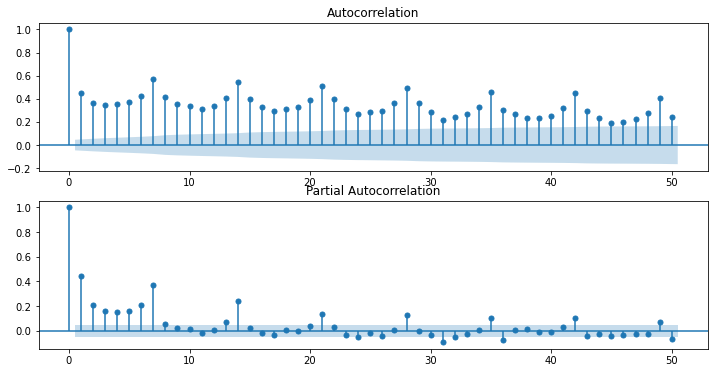

In [156]:
# For original Data
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data_1.sales, lags=50, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data_1.sales, lags=50, ax=ax2)


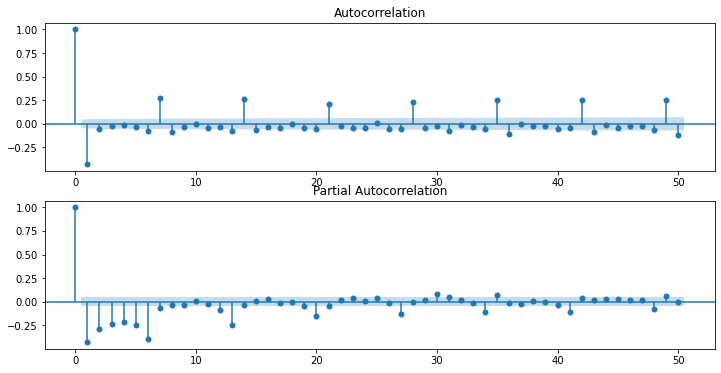

In [157]:
# For differenced data

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data_1_sales_diff, lags=50, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data_1_sales_diff, lags=50, ax=ax2)

### Observations

From the above plots, we see that first order differencing made the data stationary so I=1. We also see that every 7 days the ACF and PACF are recurring. So withing 6 lags the AR is significant.

In [158]:
#Modelling

arima_model = sm.tsa.ARIMA(train_data_1.sales, (6,1,0)).fit(disp=False)
print(arima_model.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.sales   No. Observations:                 1825
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -5597.668
Method:                       css-mle   S.D. of innovations              5.195
Date:                Thu, 26 May 2022   AIC                          11211.335
Time:                        20:25:58   BIC                          11255.410
Sample:                    01-02-2013   HQIC                         11227.594
                         - 12-31-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0039      0.025      0.152      0.879      -0.046       0.054
ar.L1.D.sales    -0.8174      0.022    -37.921      0.000      -0.860      -0.775
ar.L2.D.sales    -0.7497      0.026    -

## Residual Error Plotting

In [159]:
residual = arima_model.resid
print(normaltest(residual))

NormaltestResult(statistic=16.426387860489786, pvalue=0.00027105361095568523)


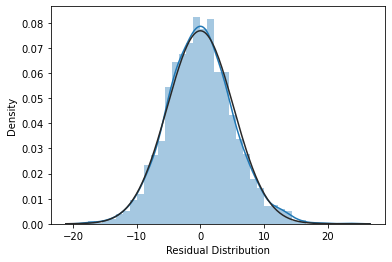

In [160]:
sns.distplot(residual, fit = stats.norm)
plt.xlabel('Residual Distribution')
plt.show()

### Perdiction & Evaluation On ARIMA

Prediction on the last 3 months

In [161]:
train_data_1.shape

(1826, 7)

In [162]:
sarima_model = sm.tsa.statespace.SARIMAX(train_data_1.sales, trend='n', order=(6,1,0)).fit()

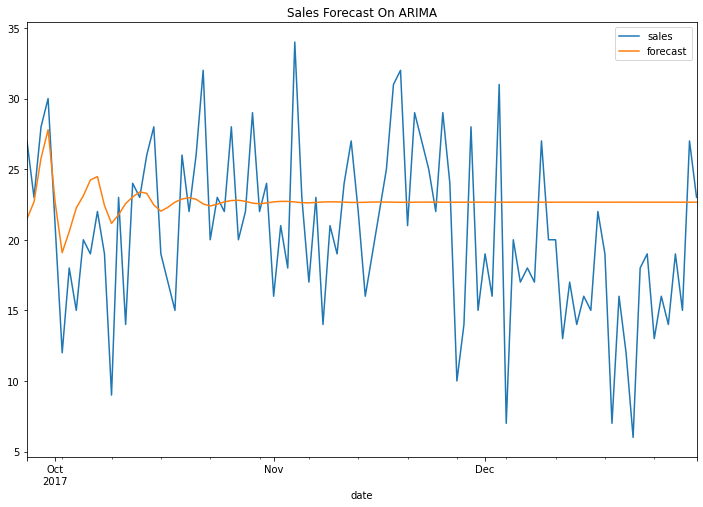

In [163]:
start_ = 1730
end_ = 1826

train_data_1['forecast'] = sarima_model.predict(start = start_, end = end_, dynamic=True)
train_data_1[start_:end_][['sales', 'forecast']].plot(figsize=(12, 8))
plt.title('Sales Forecast On ARIMA')
plt.show()

It performs poorly because we did not consider seasonality components.

In [164]:
# Mape and SMAPE

def eval(y_true, y_pred):
    mape = np.mean(abs((y_pred-y_true)/y_true))*100
    smape = np.mean(abs(y_pred-y_true)*200/(np.abs(y_pred)+np.abs(y_true)).fillna(0))
    print('MAPE: %.2f \nSMAPE: %.2f'%(mape,smape),"%")

In [165]:
eval(train_data_1[1730:1826]['sales'], train_data_1[1730:1826]['forecast'])

MAPE: 32.68 
SMAPE: 24.82 %


## SARIMA(X)

Since we found there was a clear seasonality, we need to add the seasonal terms along with external factors. The dataset is from the USA and adding public holodays might help us to improve MAPE & SMAPE

In [166]:
holidays = pd.read_csv('USBankHolidays.csv', header =None, names=['date', 'HolidayType'])

In [167]:
holidays.dtypes

date           object
HolidayType    object
dtype: object

In [168]:
holidays['date'] = pd.to_datetime(holidays['date'], format='%Y-%m-%d')
holidays.dtypes

date           datetime64[ns]
HolidayType            object
dtype: object

In [169]:
train_data_1 = train_data_1.merge(holidays, how='left', on='date')
train_data_1

,date,store,item,sales,year,month,day,weekday,forecast,HolidayType
0,2013-01-01,1,1,13,2013,1,1,1,NaN,New Year Day
1,2013-01-02,1,1,11,2013,1,2,2,NaN,NaN
2,2013-01-03,1,1,14,2013,1,3,3,NaN,NaN
3,2013-01-04,1,1,13,2013,1,4,4,NaN,NaN
4,2013-01-05,1,1,10,2013,1,5,5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2,22.661689,NaN
1822,2017-12-28,1,1,19,2017,12,28,3,22.661656,NaN
1823,2017-12-29,1,1,15,2017,12,29,4,22.661591,NaN
1824,2017-12-30,1,1,27,2017,12,30,5,22.661547,NaN


In [170]:
train_data_1['HBool'] = pd.notnull(train_data_1['HolidayType']).astype(int)
train_data_1

,date,store,item,sales,year,month,day,weekday,forecast,HolidayType,HBool
0,2013-01-01,1,1,13,2013,1,1,1,NaN,New Year Day,1
1,2013-01-02,1,1,11,2013,1,2,2,NaN,NaN,0
2,2013-01-03,1,1,14,2013,1,3,3,NaN,NaN,0
3,2013-01-04,1,1,13,2013,1,4,4,NaN,NaN,0
4,2013-01-05,1,1,10,2013,1,5,5,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
1821,2017-12-27,1,1,14,2017,12,27,2,22.661689,NaN,0
1822,2017-12-28,1,1,19,2017,12,28,3,22.661656,NaN,0
1823,2017-12-29,1,1,15,2017,12,29,4,22.661591,NaN,0
1824,2017-12-30,1,1,27,2017,12,30,5,22.661547,NaN,0


In [171]:
train_data_1 = pd.get_dummies(train_data_1, columns=['month','HolidayType', 'weekday'])
final_col = train_data_1.columns
train_data_1.shape

(1826, 37)

In [172]:
final_col

Index(['date', 'store', 'item', 'sales', 'year', 'day', 'forecast', 'HBool',
       'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'HolidayType_Christmas Day', 'HolidayType_Columbus Day',
       'HolidayType_Independence Day', 'HolidayType_Labor Day',
       'HolidayType_Martin Luther King Jr. Day', 'HolidayType_Memorial Day',
       'HolidayType_New Year Day',
       'HolidayType_Presidents Day (Washingtons Birthday)',
       'HolidayType_Thanksgiving Day', 'HolidayType_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object')

In [173]:
final_col = ['sales', 'year',  'HBool', 'month_1',
       'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7',
       'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'HolidayType_Christmas Day', 'HolidayType_Columbus Day',
       'HolidayType_Independence Day', 'HolidayType_Labor Day',
       'HolidayType_Martin Luther King Jr. Day', 'HolidayType_Memorial Day',
       'HolidayType_New Year Day',
       'HolidayType_Presidents Day (Washingtons Birthday)',
       'HolidayType_Thanksgiving Day', 'HolidayType_Veterans Day', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6']

In [174]:
train_data_1 = train_data_1.set_index('date')


In [175]:
train_data_1 = train_data_1[final_col]

In [176]:
train_data_1_copy = train_data_1.copy()
train_data_1_copy.head()

,sales,year,HBool,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,HolidayType_Christmas Day,HolidayType_Columbus Day,HolidayType_Independence Day,HolidayType_Labor Day,HolidayType_Martin Luther King Jr. Day,HolidayType_Memorial Day,HolidayType_New Year Day,HolidayType_Presidents Day (Washingtons Birthday),HolidayType_Thanksgiving Day,HolidayType_Veterans Day,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13,2013,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2013-01-02,11,2013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2013-01-03,14,2013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2013-01-04,13,2013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2013-01-05,10,2013,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [177]:
start_date = '2017-10-01'
end_date = '2017-12-31'

## Model Training & Experiments

In [178]:
#pip install pmdarima

In [179]:
from pmdarima import auto_arima

### The below cell can be commented for reproducing results. It takes a lot of time to run.

In [180]:
# Fit auto_arima function
stepwise_fit = auto_arima(train_data_1.sales[:start_date], train_data_1.drop(['sales'], axis=1)[:start_date], start_p = 1,
                          start_q = 1, max_p = 7, max_q = 7, m = 7,
                          start_P = 0, seasonal = True,d = None, 
                          D = 1, trace = True, 
                          error_action ='ignore',   
                          suppress_warnings = True,  
                          stepwise = True)           
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=33.18 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=11213.771, Time=8.58 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=10713.825, Time=29.84 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=32.19 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=11211.836, Time=7.14 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=11215.361, Time=2.84 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=10550.495, Time=52.98 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=54.59 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=34.30 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=10547.983, Time=54.01 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=10711.360, Time=31.12 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=55.19 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=37.47 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=10550.458, Time=57.12 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=10

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 1735
Model:             SARIMAX(1, 0, 1)x(2, 1, [], 7)   Log Likelihood               -5226.624
Date:                            Thu, 26 May 2022   AIC                          10525.249
Time:                                    20:53:18   BIC                          10721.618
Sample:                                01-01-2013   HQIC                         10597.886
                                     - 10-01-2017                                         
Covariance Type:                              opg                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
year                                                 -0.4198      1.087     -0.386      0.699      -2.551       1.711
HBool                                                -0.3992    727.716     -0.001      1.000   -1426.697    1425.898
month_1                                              -5.4292    500.221     -0.011      0.991    -985.844     974.986
month_2                                              -4.3278    500.281     -0.009      0.993    -984.860     976.205
month_3                                              -1.5899    500.340     -0.003      0.997    -982.239     979.059
month_4                                               1.2747    500.329      0.003      0.998    -979.352     981.901
month_5                                               2.5944    500.356      0.005      0.996    -978.085     983.274
month_6                                               4.7162    500.373      0.009      0.992    -975.997     985.429
month_7                                               5.5524    500.387      0.011      0.991    -975.188     986.293
month_8                                               1.9377    500.393      0.004      0.997    -978.816     982.691
month_9                                               0.6798    500.402      0.001      0.999    -980.091     981.450
month_10                                             -0.3410    500.400     -0.001      0.999    -981.107     980.425
month_11                                              0.9187    500.400      0.002      0.999    -979.848     981.686
month_12                                             -5.9877    500.401     -0.012      0.990    -986.755     974.780
HolidayType_Christmas Day                             0.3416    727.733      0.000      1.000   -1425.988    1426.672
HolidayType_Columbus Day                             -2.4920    727.729     -0.003      0.997   -1428.815    1423.831
HolidayType_Independence Day                          1.7316    727.713      0.002      0.998   -1424.560    1428.023
HolidayType_Labor Day                                 0.7197    727.695      0.001      0.999   -1425.536    1426.976
HolidayType_Martin Luther King Jr. Day               -0.9726    727.766     -0.001      0.999   -1427.369    1425.423
HolidayType_Memorial Day                             -1.3398    727.735     -0.002      0.999   -1427.673    1424.994
HolidayType_New Year Day                              1.4373    727.467      0.002      0.998   -1424.373    1427.247
HolidayType_Presidents Day (Washingtons Birthday)    -2.2517    727.594     -0.003      0.998   -1428.310    1423.807
HolidayType_Thanksgiving Day                          1.5556    727.726      0.002      0.998   -1424.761    1427.872
HolidayType_Veterans Day                              0.8712    7

#### Experiment 1

######## The Evaluation Of the Model - (Experiment 1) ########
MAPE: 29.16 
SMAPE: 25.29 %


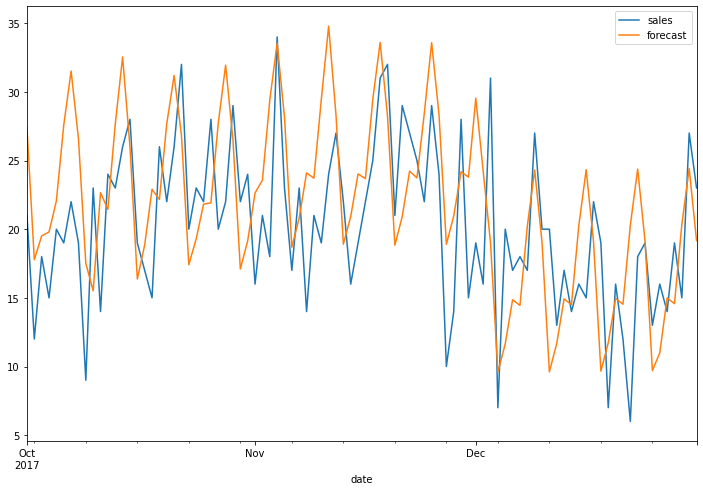

In [181]:
train_data_1_exp1 = train_data_1_copy.copy()
sarimax_model_exp1 = sm.tsa.statespace.SARIMAX(endog = train_data_1_exp1.sales[:start_date],
                                        exog = train_data_1_exp1.drop(['sales'], axis=1)[:start_date],  
                                        trend='n', order=(6,1,0), seasonal_order=(2,1,0,7)).fit()
#print(sarimax_model_exp1.summary())

train_data_1_exp1['forecast'] = sarimax_model_exp1.predict(start = pd.to_datetime(start_date), end= pd.to_datetime(end_date),
                                            exog = train_data_1_exp1.drop(['sales'], axis=1)[start_date:'2017-12-30'], 
                                            dynamic= True)  


train_data_1_exp1[start_date:end_date][['sales', 'forecast']].plot(figsize=(12, 8))

print("######## The Evaluation Of the Model - (Experiment 1) ########")
eval(train_data_1_exp1[start_date:end_date]['sales'], train_data_1_exp1[start_date:end_date]['forecast'])

#### Experiment 2

######## The Evaluation Of the Model - (Experiment 2) ########
MAPE: 27.69 
SMAPE: 24.22 %


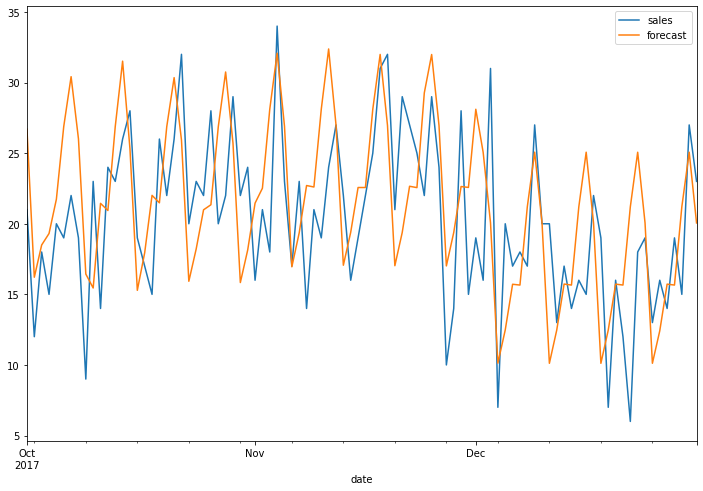

In [182]:
train_data_1_exp2 = train_data_1_copy.copy()
sarimax_model_exp2 = sm.tsa.statespace.SARIMAX(endog = train_data_1_exp2.sales[:start_date],
                                        exog = train_data_1_exp2.drop(['sales'], axis=1)[:start_date],  
                                        trend='n', order=(1,0,1), seasonal_order=(2,1,0,7)).fit()
#print(sarimax_model_exp2.summary())

train_data_1_exp2['forecast'] = sarimax_model_exp2.predict(start = pd.to_datetime(start_date), end= pd.to_datetime(end_date),
                                            exog = train_data_1_exp2.drop(['sales'], axis=1)[start_date:'2017-12-30'], 
                                            dynamic= True)  


train_data_1_exp2[start_date:end_date][['sales', 'forecast']].plot(figsize=(12, 8))

print("######## The Evaluation Of the Model - (Experiment 2) ########")
eval(train_data_1_exp2[start_date:end_date]['sales'], train_data_1_exp2[start_date:end_date]['forecast'])

#### Experiment 3

######## The Evaluation Of the Model - (Experiment 3) ########
MAPE: 29.16 
SMAPE: 25.29 %


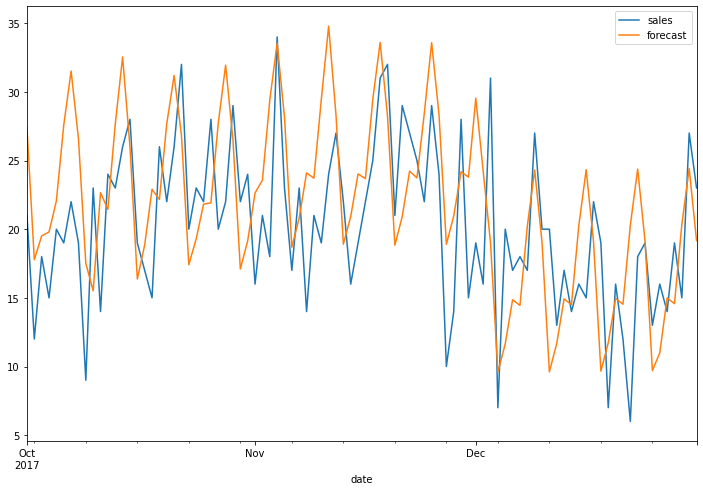

In [183]:
train_data_1_exp3 = train_data_1_copy.copy()
sarimax_model_exp3 = sm.tsa.statespace.SARIMAX(endog = train_data_1_exp3.sales[:start_date],
                                        exog = train_data_1_exp3.drop(['sales'], axis=1)[:start_date],  
                                        trend='n', order=(6,1,0), seasonal_order=(2,1,0,7)).fit()
#print(sarimax_model_exp3.summary())

train_data_1_exp3['forecast'] = sarimax_model_exp3.predict(start = pd.to_datetime(start_date), end= pd.to_datetime(end_date),
                                            exog = train_data_1_exp3.drop(['sales'], axis=1)[start_date:'2017-12-30'], 
                                            dynamic= True)  


train_data_1_exp3[start_date:end_date][['sales', 'forecast']].plot(figsize=(12, 8))

print("######## The Evaluation Of the Model - (Experiment 3) ########")
eval(train_data_1_exp3[start_date:end_date]['sales'], train_data_1_exp3[start_date:end_date]['forecast'])

#### Experiment 4

######## The Evaluation Of the Model - (Experiment 4) ########
MAPE: 26.64 
SMAPE: 21.55 %


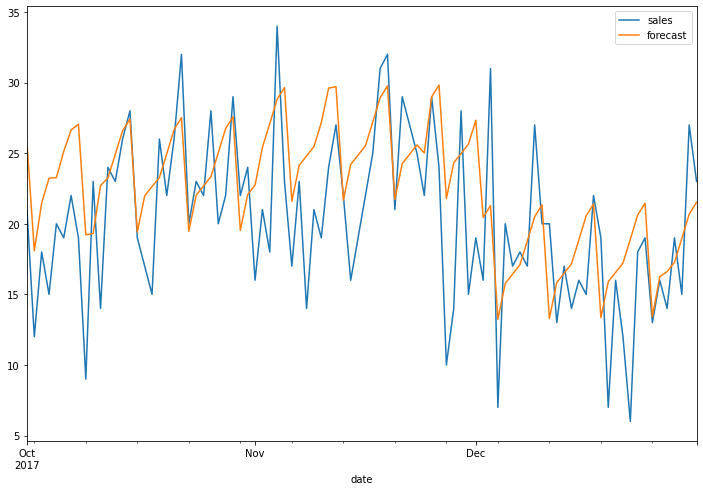

In [184]:
train_data_1_exp4 = train_data_1_copy.copy()
sarimax_model_exp4 = sm.tsa.statespace.SARIMAX(endog = train_data_1_exp4.sales[:start_date],
                                        exog = train_data_1_exp4.drop(['sales'], axis=1)[:start_date],  
                                        trend='n', order=(6,1,0), seasonal_order=(0,1,1,7)).fit()
#print(sarimax_model_exp4.summary())

train_data_1_exp4['forecast'] = sarimax_model_exp4.predict(start = pd.to_datetime(start_date), end= pd.to_datetime(end_date),
                                            exog = train_data_1_exp4.drop(['sales'], axis=1)[start_date:'2017-12-30'], 
                                            dynamic= True)  


train_data_1_exp4[start_date:end_date][['sales', 'forecast']].plot(figsize=(12, 8))

print("######## The Evaluation Of the Model - (Experiment 4) ########")
eval(train_data_1_exp4[start_date:end_date]['sales'], train_data_1_exp4[start_date:end_date]['forecast'])

## Result Discussion

This Notebook focused on implementation of statistical models like ARIMA & SARIMA(X) on the Supply Chain data. The below observations were found during the experiments.

- The models are very fast to train and the optimal parameters can be found using various statistical tests such as Dickey-Fuller test, data visualization technique on Homosedasticity.

- Considerable amount of time is required for finding the right/ optimal parameters Of ARIMA and SARIMAX(p,d,q) (P,D,Q)S (X). Best performing parameters were <b>order=(6,1,0), seasonal_order=(0,1,1,7)</b>

- Significant improvement in results were observed when US holiday External data was imported and merged with the main data set. This reduced the MAPE score by 6%. 
<b> Drawbacks</b>
Implementing statistical models such as ARIMA, SARIMA, SARIMAX on a data like this, where we have 500 combinations of Store & Item, will require considerable time. As each combination will have to be trained separately for Store-Article prediction. Meaning 500 models needs to be trained and for each model specific optimal parameters will have to be found and trained upon.

- One solution can be to use the Hierarchical clustering methodology suchh as the one provided in the paper from <b>Jakob Huber et al. 2017</b>(link below). Another way is to modify the problem from a pure time series into Supervised machine learning by generating  time lag, time shift features and using powerful algorithms such as LightGBMs. <b>I have uploaded another Notebook with LightGBM implemetation where the MAPE was reduced by further 12% points.</b>
https://www.sciencedirect.com/science/article/pii/S0957417417300313